Experiment for the paper "Features for discourse-new referent detection in Russian
==============================================
Replication of CICLing-2016 paper (Toldova and Ionov 2016)
-------------------------------------

To reproduce this experiment you will need:
1. [RuCor corpus (from 2015-10-29)](http://rucoref.maimbava.net/files/rucoref_29.10.2015.zip)
2. Python modules:
  * [`scikit-learn`](http://scikit-learn.org/stable/install.html) (v. 0.22.1)
  * [`imbalanced-learn`](https://imbalanced-learn.org/stable/install.html) (v. 0.6.2)
  * [`matplotlib`](http://matplotlib.org/users/installing.html) (v. 3.1.3)
2. `anaphoralib` [Python module](https://github.com/max-ionov/rucoref)

Since `anaphoralib` is in an early stage of development, there is no way to install it yet, so in order to import it, you should `cd` to the folder with the module. Paths to the corpus should be updated accordingly.

In [1]:
%cd '/Users/max/Projects/Coreference/'

/Users/max/Projects/Coreference


In [2]:
%cd 'rucoref'
from anaphoralib.corpora import rueval
from anaphoralib.tagsets import multeast
from anaphoralib.experiments.base import BaseClassifier
from anaphoralib import utils
from anaphoralib.experiments import utils as exp_utils
%cd '..'

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import BorderlineSMOTE

import numpy as np

%matplotlib inline

/Users/max/Projects/Coreference/rucoref
/Users/max/Projects/Coreference


In [3]:
lists_dir = 'CICLing-2016/wordlists'
texts_dir = 'Corpus-2015/Tokens.txt'
gs_dir = 'Corpus-2015/Groups.txt'

tagset = multeast

random_state = 42

Reading the texts from GS and matching them to actual texts
--------------

### Loading chains and GS

In [4]:
rucoref = rueval.RuCorefCorpus(multeast, rueval)

In [5]:
exp_utils.load_corpus(rucoref, texts_dir, gs_dir)

Number of texts: 181
Number of GS texts: 181
Number of chains in a corpus: 3383
Number of words in all chains: 15886


In [6]:
rucoref.groups[0][:30]

[Во:во(Sp-a, 0),
 время своих прогулок:время свой прогулка(Ncnsan, 3),
 в:в(Sp-l, 24),
 окрестностях Симеиза:окрестность симеиза(Ncfpln, 26),
 я:я(P-1-snn, 47),
 обратил:обратить(Vmis-sma-p, 49),
 внимание:внимание(Ncnsan, 57),
 на:на(Sp-a, 66),
 одинокую дачу:одинокий дача(Ncfsan, 69),
 стоявшую:стоять(Vmps-sfa-ea, 84),
 на:на(Sp-l, 93),
 крутом склоне:крутой склон(Ncmsln, 96),
 горы:гора(Ncfpan, 110),
 .:.(SENT, 114),
 К:к(Sp-l, 116),
 этой даче:этот дача(Ncfsln, 118),
 не:не(Q-----, 128),
 было:быть(Vmis-sna-e, 131),
 проведено:провести(Vmps-snpsp, 136),
 даже:даже(Q-----, 146),
 дороги:дорогой(Afpmpns, 151),
 .:.(SENT, 157),
 Кругом:кругом(R-----, 159),
 она:она(P-3fsnn, 166),
 была:быть(Vmis-sfa-e, 170),
 обнесена:обнесена(Vmps-sfpsp, 175),
 высоким забором:высокий забор(Ncmsin, 184),
 с:с(Sp-i, 201),
 единственной низкой калиткой:единственный низкий калитка(Ncfsin, 203),
 которая:который(P--fsna, 233)]

In [7]:
rucoref.print_stats()

Number of texts: 181
Number of GS texts: 181
Number of chains in a corpus: 3383
Number of words in all chains: 15886


In [8]:
rucoref.create_indices()

### Loading special lists
Special lists load from the directory stored in `lists_dir`

In [9]:
def load_list(filename):
    data = set()
    with open(filename, encoding='utf-8') as inp_file:
        for line in inp_file:
            data.add(line.strip('\r\n'))
    
    return data

In [10]:
import os

wordlists = {}

for filename in os.listdir(lists_dir):
    wordlists[filename.replace('.txt', '')] = load_list(os.path.join(lists_dir, filename))

In [11]:
print(wordlists.keys())

dict_keys(['role_assess', 'NewRef', 'class', 'indef', 'refer_to_CommKnowl', 'adj-top50', 'non-identity_sim', 'demonstratives', 'possessives', 'subjectivity'])


### Building indices and dictionaries

Building additional indices (of all words and all groups):

In [12]:
import collections

word_index = []
group_index = []

for i, text in enumerate(rucoref.texts):
    word_index.append(collections.defaultdict(set))
    group_index.append(collections.defaultdict(set))
    
    for word in text:
        word_index[-1]['_'.join(word.lemma)].add(word.offset)
    for group in rucoref.groups[i]:
        for g in group.iter_groups():
            group_index[-1]['_'.join(g.lemma)].add(g.offset)

In [13]:
print('\n'.join(list(group_index[0].keys())[:30]))

во
время_свой_прогулка
время
свой
прогулка
в
окрестность_симеиза
окрестность
симеиза
я
обратить
внимание
на
одинокий_дача
одинокий
дача
стоять
крутой_склон
крутой
склон
гора
.
к
этот_дача
этот
не
быть
провести
даже
дорогой


Building sets of adjectives and pronouns for feature selection:

In [14]:
adjectives = set()
for text in rucoref.texts:
    for word in text:
        if tagset.pos_filters['adj'](word) and (len(word.tag) < 7 or word.tag[6] == 'f'):
            adjectives.add('_'.join(word.lemma))

adjectives = list(adjectives)

In [15]:
adjectives

['нечестивый',
 'движущий',
 'викторианский',
 'водоочистных',
 'далёкие',
 'множественный',
 'наглядный',
 'медийной',
 'расового',
 'швейцарский',
 'страховой',
 'недлинной',
 'национально',
 'разветвлённых',
 'заграничный',
 'нелогичный',
 'восхитительный',
 'полярный',
 'близлежащими',
 'приятный',
 'запасной',
 'псевдовикторианский',
 'развевающегося',
 'престижнейшее',
 'смелый',
 'чикагского',
 'запредельный',
 'худобой',
 'острый',
 'жёсткой',
 'этническое',
 'многосторонние',
 'ненадежный',
 'презренном',
 'нечастый',
 'тёплом',
 'цинковый',
 'толстый',
 'астрономический',
 'избирательный',
 'малоизвестный',
 'отработавшее',
 'интригующий',
 'дружный',
 'небесный',
 'мюнхенский',
 'озоновом',
 'окровавленный',
 'равномерный',
 '\ufeffавторское',
 'польский',
 'пространственный',
 'густой',
 'видимый',
 'проникновенными',
 'хазарский',
 'документальную',
 'всемирный',
 'номинативный',
 'волонтерская',
 'плохонький',
 'дворцовый',
 'обычный',
 'локальный',
 'круглый',
 'жёстким'

In [16]:
pronouns = set()
for text in rucoref.texts:
    for word in text:
        if tagset.pos_filters['pronoun'](word):
            pronouns.add('_'.join(word.lemma))

pronouns = list(pronouns)

In [17]:
pronouns

['каков',
 'который',
 'мой',
 'ваш',
 'своё',
 'прочее',
 'их',
 'нечто',
 'один',
 'некий',
 'они',
 'некоторый',
 'тот',
 'твой',
 'аз',
 'это',
 'никой',
 'таковой',
 'немногие',
 'таков',
 'я',
 'свой',
 'себя',
 'многие',
 'немногий',
 'его',
 'никто',
 'ничто',
 'кто',
 'другое',
 'всякий',
 'он',
 'каждый',
 'всём',
 'любой',
 'самый',
 'вы',
 'иной',
 'никакой',
 'она',
 'наш',
 'другой',
 'оно',
 'ее',
 'прочий',
 'ничей',
 'сей',
 'чей',
 'друг',
 'дружка',
 'такой',
 'кой',
 'весь',
 'сам',
 'мы',
 'все',
 'данный',
 'ты',
 'многое',
 'сие',
 'какой',
 'остальной',
 'е',
 'каковой',
 'некого',
 'нечего',
 'наша',
 'эдакий',
 'что',
 'многий',
 'этот',
 'то']

### Creating a classifier

In [18]:
import re

class FirstMentionClassifier(BaseClassifier):
    def __init__(self):
        super(FirstMentionClassifier, self).__init__()
        
        self.feat_zones_ = ('struct', 'string', 'lists')
        self.stats = {'str_matches_before', 'head_matches_before', 'n_adj', 'len_np'}
        
        self.rx_lat = re.compile('[A-Za-z]')
        self.pronouns = {u"его", u"ее", u"её", u"ей", u"ему", u"ею", u"им", u"ими", u"их", u"которая", 
                u"которого", u"которое", u"которой", u"котором", u"которому", u"которую", u"которые", 
                u"который", u"которым", u"которыми", u"которых", u"него", u"нее", u"неё", u"ней", u"нем", 
                u"нём", u"нему", u"нею", u"ним", u"ними", u"них", u"он", u"она", u"они", u"оно", u"свое", 
                u"своё", u"своего", u"своей", u"своем", u"своём", u"своему", u"своею", u"свой", u"свои", 
                u"своим", u"своими", u"своих", u"свою", u"своя", u"себе", u"себя", u"собой", u"собою"}
        
        self.clear_stats()
        
    def get_feature_vector(self, corpus, group, i_text, save_feature_names=False):
        if save_feature_names:
            self.feature_names_ = []
            
        vctr = []
        
        group_lemma = '_'.join(group.lemma)
        group_occurrences = group_index[i_text][group_lemma] if group_lemma in group_index[i_text] else []

        head_index = group.head
        head_lemma = group.lemma[group.head]
        head_occurrences = word_index[i_text][head_lemma] if head_lemma in word_index[i_text] else []
        head_offset = group.head_offset

        group_words = group.words if group.type != 'word' else [group]

        str_matches_before = sum(1 for occ in group_occurrences if occ < group.offset)
        head_matches_before = sum(1 for occ in head_occurrences if occ < group.offset)
        
        adj_in_group = [word for word in group_words[:head_index+1] if tagset.pos_filters['adj'](word)]
        
        self.stats['str_matches_before'].append(str_matches_before)
        self.stats['head_matches_before'].append(head_matches_before)
        
        self.stats['n_adj'].append("{}: {}".format(len(adj_in_group), group_lemma))
        self.stats['len_np'].append("{}: {}".format(len(group_words), group_lemma))
        
        if 'string' in self.feat_zones_:
            vctr.append(('str_match_before=0', str_matches_before == 0))
            vctr.append(('str_match_before<2', str_matches_before < 2))
            vctr.append(('str_match_before<3', str_matches_before < 3))
            vctr.append(('str_match_before>2', str_matches_before > 2))

            vctr.append(('head_match_before=0', head_matches_before == 0))
            vctr.append(('head_match_before<2', head_matches_before < 2))
            vctr.append(('head_match_before<3', head_matches_before < 3))
            vctr.append(('head_match_before>2', head_matches_before > 2))
            
            vctr.append(('uppercase', all(word.isupper() and len(word) > 1 for word in group.wordform)))
            #vctr.append(('capitalized', any(word[0].isupper() and len(group.wordform) > 1 for word in group.wordform[1:])))
            vctr.append(('latin', any(self.rx_lat.search(word) for word in group.wordform)))
            vctr.append(('is_proper_noun', corpus.tagset.pos_filters['properNoun'](group)))
        #vctr.append(('is_pronoun', group.lemma[0] in pronouns))
        vctr.append(('is_pronoun', group.wordform[0] in self.pronouns))
        #vctr.append(('is_pronoun', multeast.pos_filters['pronoun'](group) or group.wordform[0] in pronouns))
        self.n_pronouns += 1
        
        if 'struct' in self.feat_zones_:
            i_word = corpus.words_index[i_text][group.offset]
            left_word = corpus.texts[i_text][i_word - 1] if i_word > 0 else None
            right_word = corpus.texts[i_text][i_word + len(group.wordform) + 1] \
                                if i_word + len(group.wordform) + 1 < len(corpus.texts[i_text]) else None
            vctr.append(('conj', bool((left_word and corpus.tagset.pos_filters['conj'](left_word)) 
                        or (right_word and corpus.tagset.pos_filters['conj'](right_word)))))
            
            vctr.append(('len_np<2', len(group.tags) < 2))
            vctr.append(('len_np>2', len(group.tags) > 2))
            
            vctr.append(('n_adj=0', len(adj_in_group) == 0))
            vctr.append(('n_adj>1', len(adj_in_group) > 1))
            vctr.append(('n_adj>2', len(adj_in_group) > 2))
            
        if 'lists' in self.feat_zones_:
            for l in wordlists:
                vctr.append(('in_list_{}'.format(l), any(lemma in wordlists[l] for lemma in group.lemma[:head_index+1])))
        
        if save_feature_names:
            self.feature_names_ = [feat[0] for feat in vctr]
        
        return [int(feat[1]) for feat in vctr]
    
    def prepare_data(self, corpus, random_state=42, test_size=0.3, feature_zones=None):
        if feature_zones:
            self.feat_zones_ = feature_zones
        
        self.n_pronouns = 0
        
        self.stats['class'] = []
        
        self.groups = []
        self.x_data = []
        self.y_data = []

        self.cur_data_ = 'Binary, filtered singletons'
        self.class_names_ = ('non-first', 'first')
        
        save_features = True
    
        for i_text, text in enumerate(corpus.texts):
            for i, mention in enumerate(corpus.mentions[i_text]):
                if i not in rucoref.gs_index[i_text]:
                    continue
                    
                cur_gs_group_id = corpus.gs_index[i_text][i]
                cur_chain = corpus.gs[i_text]['chains'][corpus.chains_index[i_text][cur_gs_group_id]]

                self.y_data.append(self.class_names_.index('first') if cur_gs_group_id == cur_chain[0] 
                                   else self.class_names_.index('non-first'))

                group = corpus.heads_index[i_text][mention.offset]
                self.x_data.append(self.get_feature_vector(corpus, group, i_text, save_features))
                self.groups.append(group)
                self.stats['class'].append(self.class_names_[self.y_data[-1]])
                save_features = False

                pronoun_index = self.feature_names_.index('is_pronoun')
                if self.x_data[-1][pronoun_index]:
                    self.x_data.pop()
                    self.y_data.pop()
                    self.groups.pop()
                    for key in self.stats:
                        self.stats[key].pop()
                    continue
                
                del self.x_data[-1][pronoun_index]
                
        super(FirstMentionClassifier, self).prepare_data(corpus, random_state, test_size)
    
        del self.feature_names_[pronoun_index]
        class_numbers = [sum(1 for item in self.y_data if item == cur_class) for cur_class in range(len(self.class_names_))]
        self.ratio = float(min(class_numbers) / float(max(class_numbers)))

### Training and testing

In [19]:
first_mention_clf = FirstMentionClassifier()
first_mention_clf.prepare_data(rucoref, random_state=random_state, test_size=0.3)

In [20]:
first_mention_clf.stats.keys()

dict_keys(['len_np', 'head_matches_before', 'n_adj', 'str_matches_before', 'class'])

#### Baseline

Baseline condition: NP is a first mention if there is no such exact string in the text before

In [22]:
def baseline_predict(data):
    y_pred = np.zeros(len(data))
    for i, row in enumerate(data):
        y_pred[i] = row[0] == 1
    
    return y_pred

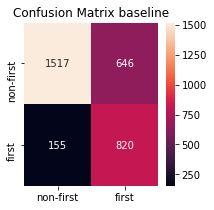

Report baseline:               precision    recall  f1-score   support

   non-first      0.907     0.701     0.791      2163
       first      0.559     0.841     0.672       975

    accuracy                          0.745      3138
   macro avg      0.733     0.771     0.731      3138
weighted avg      0.799     0.745     0.754      3138



In [23]:
first_mention_clf.test(y_pred=baseline_predict(first_mention_clf.x_data_test), test_name='baseline')

#### String features

In [24]:
first_mention_clf.prepare_data(rucoref, random_state=random_state, feature_zones=('string',))

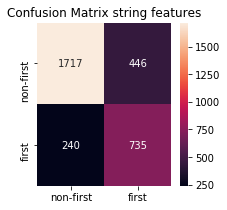

Report string features:               precision    recall  f1-score   support

   non-first      0.877     0.794     0.833      2163
       first      0.622     0.754     0.682       975

    accuracy                          0.781      3138
   macro avg      0.750     0.774     0.758      3138
weighted avg      0.798     0.781     0.786      3138



In [25]:
clf = RandomForestClassifier(n_estimators=500, random_state=random_state)
sampler = BorderlineSMOTE(sampling_strategy=first_mention_clf.ratio, kind='borderline-1', random_state=random_state)

first_mention_clf.fit(clf, sampler)
first_mention_clf.test(test_name='string features')

In [26]:
first_mention_clf.print_stats()

Classifier <class 'sklearn.ensemble._forest.RandomForestClassifier'>: fitted
Data: Binary, filtered singletons (non-first, first)
Total:	10460 samples
	7384 non-first
	3076 first


#### String + Struct features

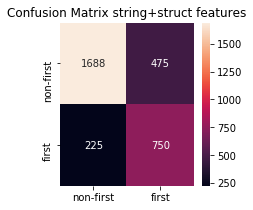

Report string+struct features:               precision    recall  f1-score   support

   non-first      0.882     0.780     0.828      2163
       first      0.612     0.769     0.682       975

    accuracy                          0.777      3138
   macro avg      0.747     0.775     0.755      3138
weighted avg      0.798     0.777     0.783      3138



In [27]:
first_mention_clf = FirstMentionClassifier()
first_mention_clf.prepare_data(rucoref, random_state=random_state, feature_zones=('string', 'struct'))
clf = RandomForestClassifier(n_estimators=500, random_state=random_state)
sampler = BorderlineSMOTE(sampling_strategy=first_mention_clf.ratio, kind='borderline-1', random_state=random_state)

first_mention_clf.fit(clf, sampler)
first_mention_clf.test(test_name='string+struct features')

#### All features

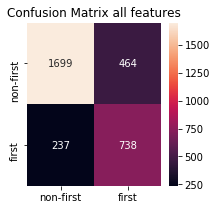

Report all features:               precision    recall  f1-score   support

   non-first      0.878     0.785     0.829      2163
       first      0.614     0.757     0.678       975

    accuracy                          0.777      3138
   macro avg      0.746     0.771     0.753      3138
weighted avg      0.796     0.777     0.782      3138



In [28]:
first_mention_clf = FirstMentionClassifier()
first_mention_clf.prepare_data(rucoref, random_state=random_state, feature_zones=('string', 'struct', 'lists'))
clf = RandomForestClassifier(n_estimators=500, random_state=random_state)
sampler = BorderlineSMOTE(sampling_strategy=first_mention_clf.ratio, kind='borderline-1', random_state=random_state)

first_mention_clf.fit(clf, sampler)
first_mention_clf.test(test_name='all features')

### Calculating feature importances

In [29]:
first_mention_clf = FirstMentionClassifier()
first_mention_clf.prepare_data(rucoref, random_state=random_state, feature_zones=('string', 'struct', 'lists'))
regr = LogisticRegression(random_state=random_state, max_iter=250)
sampler = BorderlineSMOTE(sampling_strategy=first_mention_clf.ratio, kind='borderline-1', random_state=random_state)

first_mention_clf.fit(regr, sampler)

In [30]:
for i, feat_name in enumerate(first_mention_clf.feature_names_):
    print('{}: {:.4f}'.format(feat_name, regr.coef_[0,i]))

str_match_before=0: 0.9847
str_match_before<2: 0.1106
str_match_before<3: 0.3301
str_match_before>2: -0.3314
head_match_before=0: 1.2262
head_match_before<2: 0.2737
head_match_before<3: -0.0805
head_match_before>2: 0.0792
uppercase: -0.4706
latin: 0.0018
is_proper_noun: -0.5107
conj: -0.0641
len_np<2: -0.0665
len_np>2: 0.2403
n_adj=0: -0.0865
n_adj>1: 0.1248
n_adj>2: -0.5555
in_list_role_assess: -0.0063
in_list_NewRef: -0.6314
in_list_class: 1.0309
in_list_indef: 1.2202
in_list_refer_to_CommKnowl: 0.2608
in_list_adj-top50: 1.2138
in_list_non-identity_sim: 0.5401
in_list_demonstratives: -1.1104
in_list_possessives: -1.3570
in_list_subjectivity: -0.3670


## Additional actions

### Counting feature importances for bag-of-adjectives classifier

In [31]:
import sklearn.feature_extraction.text
adj_vectorizer = sklearn.feature_extraction.text.CountVectorizer(vocabulary=adjectives)
pron_vectorizer = sklearn.feature_extraction.text.CountVectorizer(vocabulary=pronouns)

In [32]:
def additional_features(data, vectorizer):
    additional_features = np.zeros(shape=(len(data), len(vectorizer.vocabulary)))
    for i, row in enumerate(data):
        additional_features[i,:] = vectorizer.transform([u' '.join(row.lemma)]).toarray()
    
    return additional_features

In [33]:
from sklearn.preprocessing import MinMaxScaler

def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 4), ranks)
    return dict(zip(names, ranks ))

In [34]:
add_data_x = additional_features(first_mention_clf.groups_train, adj_vectorizer)
adj_clf = RandomForestClassifier(random_state=random_state)
adj_clf.fit(add_data_x, first_mention_clf.y_data_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [35]:
ranks = rank_to_dict(adj_clf.feature_importances_, adj_vectorizer.vocabulary)

for feat_name in sorted(ranks, key=lambda f: ranks[f], reverse=True):
    print(feat_name, ranks[feat_name])

некоторые 1.0
каждый 0.7591
другой 0.6098
первый 0.5619
международный 0.5327
трудовой 0.4102
широкий 0.4074
огромный 0.4019
единственный 0.385
взрослый 0.3838
собственный 0.3797
небольшой 0.3564
социальный 0.3555
глобальный 0.3493
последний 0.3484
высокий 0.3451
природный 0.3442
московский 0.3403
главный 0.3017
мелкий 0.3011
солнечный 0.2968
западный 0.2935
основной 0.29
торговый 0.284
народный 0.279
русский 0.2789
одинокий 0.2742
большой 0.2741
рабочий 0.2738
административный 0.2697
оппозиционный 0.2677
зеленый 0.2639
исторический 0.2578
такой 0.2566
исламское 0.2543
общественный 0.2539
религиозный 0.253
экономический 0.2509
окружной 0.25
его 0.2428
футбольный 0.24
государственный 0.2395
всемирный 0.2378
сильный 0.2351
новый 0.2337
земной 0.2283
местный 0.2228
прекрасный 0.2227
голый 0.2207
постоянный 0.215
правый 0.2127
отдельный 0.2127
женский 0.2119
наивный 0.2106
очередной 0.2043
бедный 0.2014
знакомый 0.2007
легендарный 0.1969
активный 0.1967
железный 0.1963
лондонский 0.1867
нем

вкусовой 0.0
зажигательный 0.0
разнатовких 0.0
израильский 0.0
властный 0.0
классический 0.0
﻿соответствующая 0.0
родовспомогательное 0.0
табачный 0.0
трогательный 0.0
фарфоровый 0.0
распространяющий 0.0
скандальный 0.0
садовый 0.0
дешевый 0.0
формальный 0.0
дыхательными 0.0
﻿самая 0.0
малоприятный 0.0
захаржевскому 0.0
отвисшей 0.0
неудачный 0.0
задвинутый 0.0
спутниковый 0.0
однозначной 0.0
худший 0.0
миллионной 0.0
бросовое 0.0
широкомасштабный 0.0
неуместный 0.0
юношеский 0.0
резинотехнических 0.0
углекислый 0.0
топливный 0.0
характерный 0.0
дохийского 0.0
тарантиновских 0.0
махровый 0.0
невыясненными 0.0
студенческий 0.0
диковатый 0.0
недофинансированным 0.0
зелёное 0.0
﻿российская 0.0
высокопоставленный 0.0
концертными 0.0
южнокорейский 0.0
кавказский 0.0
аляповатый 0.0
всесторонний 0.0
спасительный 0.0
казненному 0.0
глубочайшая 0.0
учтивой 0.0
ударный 0.0
фетровый 0.0
абстрактный 0.0
общеимперским 0.0
спиччебубио 0.0
джазовыми 0.0
нормальный 0.0
поддающемся 0.0
полутеней 0.0
не

классовый 0.0
полуспящих 0.0
перемещённые 0.0
смехотворный 0.0
выраженный 0.0
затяжной 0.0
онкологического 0.0
одинаковый 0.0
веселый 0.0
синтетический 0.0
глазной 0.0
излишний 0.0
объективный 0.0
расходуемых 0.0
полосатый 0.0
невинный 0.0
своём 0.0
слабейшая 0.0
грядущий 0.0
хиленькие 0.0
ландшафтному 0.0
межконтинентального 0.0
зримый 0.0
специфический 0.0
трансатлантические 0.0
спящей 0.0
древнеегипетский 0.0
земляничного 0.0
кислый 0.0
носатый 0.0
твёрдых 0.0
﻿гражданская 0.0
долгосрочном 0.0
душевный 0.0
распространённое 0.0
племенной 0.0
аморальный 0.0
иглокожих 0.0
приобретшие 0.0
сказочный 0.0
заключённым 0.0
израильтянских 0.0
вольготный 0.0
эластичный 0.0
мадридский 0.0
﻿смутное 0.0
отверженный 0.0
обогащённого 0.0
революционный 0.0
сетевом 0.0
неладный 0.0
зашумлённой 0.0
неимоверная 0.0
незабываемого 0.0
﻿латексное 0.0
﻿сегодняшнее 0.0
тропический 0.0
сыктывкарский 0.0
﻿олицетворяемые 0.0
подчиненный 0.0
мультимедийный 0.0
вещательные 0.0
керосиновый 0.0
двадцатидвухлетний 

дядином 0.0
пояснительный 0.0
пожнивных 0.0
платиновым 0.0
скорый 0.0
таллиннских 0.0
хемингуэевские 0.0
нерешительный 0.0
пропагандистский 0.0
банковский 0.0
сладкий 0.0
смутный 0.0
хамовническом 0.0
антияпонского 0.0
монреальскому 0.0
обступившую 0.0
гречневый 0.0
углублённом 0.0
шотландский 0.0
технологическое 0.0
анатомическими 0.0
мурманской 0.0
мозолистый 0.0
националистической 0.0
утончёнными 0.0
пуштунский 0.0
жилищный 0.0
прихотливый 0.0
дальновидный 0.0
суммарный 0.0
непредвиденный 0.0
заказной 0.0
пеньковый 0.0
старательный 0.0
противовоспалительные 0.0
безсмысленное 0.0
программный 0.0
безмерный 0.0
дверной 0.0
мещанскую 0.0
﻿таким 0.0
алеутские 0.0
﻿осторожнее 0.0
механический 0.0
продолжающимися 0.0
продвинутое 0.0
планшетный 0.0
упреждающего 0.0
непочатой 0.0
казачьем 0.0
мутный 0.0
киевский 0.0
лицензионный 0.0
саксофонную 0.0
надзорного 0.0
носовой 0.0
агрессивный 0.0
конкретный 0.0
чумной 0.0
миротворческий 0.0
кремовый 0.0
аккуратный 0.0
сердоликовые 0.0
цивилизованн

комический 0.0
упрямый 0.0
﻿взрослые 0.0
лингвистический 0.0
прибалтийский 0.0
безнадежный 0.0
экранных 0.0
соляный 0.0
бергмановским 0.0
сибирский 0.0
былой 0.0
братским 0.0
внешнеполитической 0.0
вселенский 0.0
кровожадный 0.0
ракообразными 0.0
незапамятный 0.0
хирургичский 0.0
сереющим 0.0
внимательный 0.0
прооперировавшие 0.0
длительный 0.0
откровенный 0.0
неродная 0.0
боповые 0.0
интеллектуальный 0.0
лёгкие 0.0
миноритарный 0.0
наблюдательный 0.0
невымытыми 0.0
аналогичный 0.0
несанкционированная 0.0
мирскую 0.0
умеренный 0.0
струнный 0.0
буддистских 0.0
﻿мобильных 0.0
негромкий 0.0
ирландский 0.0
робкий 0.0
скучный 0.0
жирный 0.0
метровый 0.0
великодушному 0.0
﻿подлинное 0.0
пятиэтажный 0.0
высокоточном 0.0
калашной 0.0
принудительный 0.0
﻿регулярные 0.0
лидерству 0.0
орбитальный 0.0
харьковский 0.0
запретительных 0.0
пивоваренный 0.0
сеульской 0.0
невкусный 0.0
﻿самыми 0.0
поточный 0.0
кашмирский 0.0
поповский 0.0
69—95 0.0
откатного 0.0
бытовой 0.0
дырявый 0.0
коренной 0.0
иллю

### Getting feature distributions

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import anaphoralib.experiments.utils

In [37]:
first_mention_clf = FirstMentionClassifier()
first_mention_clf.prepare_data(rucoref, random_state=random_state, feature_zones=('string', 'struct', 'lists'))

feature_distributions = {}
for feat_name in first_mention_clf.stats:
    feature_distributions[feat_name] = {cls: [] for cls in first_mention_clf.class_names_ + ('total',)}
    
    for i, elem in enumerate(first_mention_clf.stats['class']):
        feature_distributions[feat_name][elem].append(first_mention_clf.stats[feat_name][i])
        feature_distributions[feat_name]['total'].append(first_mention_clf.stats[feat_name][i])

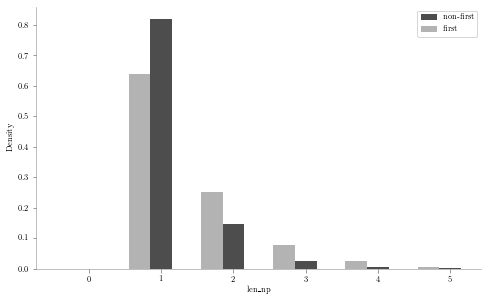

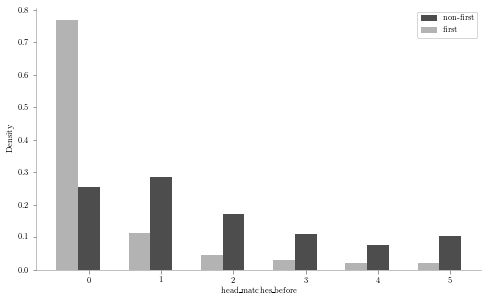

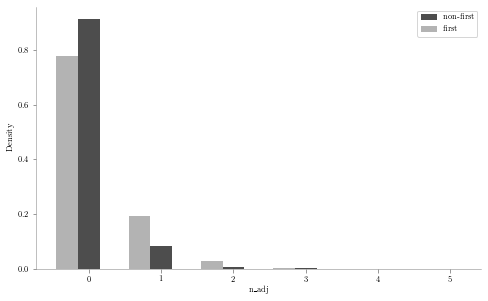

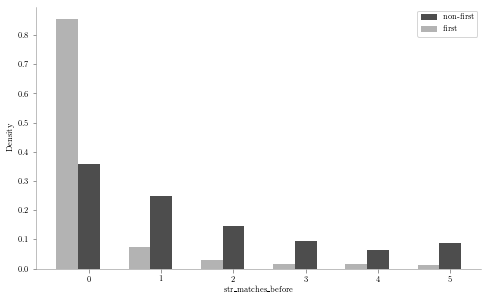

In [38]:
import os

anaphoralib.experiments.utils.latexify(columns=2)
for feat_name in feature_distributions:
    if feat_name == 'class':
        continue
    anaphoralib.experiments.utils.plot_feature_distribution(feature_distributions[feat_name], 
                                                            range(7),
                                                            first_mention_clf.class_names_, 
                                                            x_label=feat_name.replace('_', '\\_'), 
                                                            filename=os.path.join('CICLing-2016', feat_name))

In [39]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, f1_score
from sklearn.utils import shuffle

In [40]:
first_mention_clf = FirstMentionClassifier()
first_mention_clf.prepare_data(rucoref, random_state=random_state, feature_zones=('string', 'struct', 'lists'))
clf = RandomForestClassifier(n_estimators=500, random_state=random_state)

In [41]:
shuffled_x_data, shuffled_y_data = shuffle(first_mention_clf.x_data, first_mention_clf.y_data, 
                                           random_state=random_state)

train_sizes_abs, train_scores, test_scores = learning_curve(clf, 
                                                            shuffled_x_data,
                                                            shuffled_y_data,
                                                            cv=3,
                                                            scoring=make_scorer(f1_score, pos_label=1))

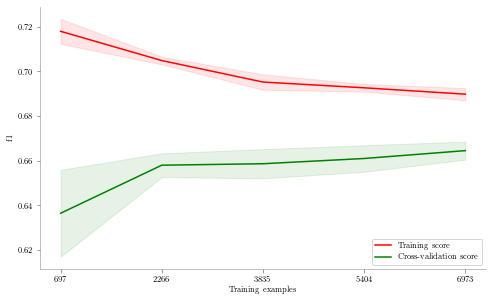

In [42]:
anaphoralib.experiments.utils.latexify(columns=2)
anaphoralib.experiments.utils.plot_learning_curve(train_sizes_abs, 
                                                  train_scores, test_scores, 
                                                  score_name='f1',
                                                  filename=os.path.join('CICLing-2016', 'learning_curve_plot'))